In [ ]:
 from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from prophet import Prophet
from prophet.diagnostics import performance_metrics,cross_validation
from sklearn.model_selection import train_test_split

**Reading the train and test csvs**

In [ ]:
train = pd.read_csv('./train.csv')
train

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


In [ ]:
test = pd.read_csv('./test.csv')
test

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False
...,...,...,...,...
115059,45,98,2013-06-28,False
115060,45,98,2013-07-05,False
115061,45,98,2013-07-12,False
115062,45,98,2013-07-19,False


**Simple Feature Engineering with preprocessing**

In [ ]:
def transform(X):
  X['Date'] = pd.to_datetime(X['Date'])
  X['Year'] = X['Date'].dt.year
  X['Month'] = X['Date'].dt.month
  X['Day'] = X['Date'].dt.day
  X['Dayofweek'] = X['Date'].dt.dayofweek
  X['Weekofyear'] = X['Date'].dt.isocalendar().week.astype(int)
  if 'Weekly_Sales' in X.columns.tolist():
    X['lag1'] = X['Weekly_Sales'].shift(1)
    X['lag4'] = X['Weekly_Sales'].shift(4)
  return X

In [ ]:
train = transform(train)
train

,Store,Dept,Date,Weekly_Sales,IsHoliday,Year,Month,Day,Dayofweek,Weekofyear,lag1,lag4
0,1,1,2010-02-05,24924.50,False,2010,2,5,4,5,NaN,NaN
1,1,1,2010-02-12,46039.49,True,2010,2,12,4,6,24924.50,NaN
2,1,1,2010-02-19,41595.55,False,2010,2,19,4,7,46039.49,NaN
3,1,1,2010-02-26,19403.54,False,2010,2,26,4,8,41595.55,NaN
4,1,1,2010-03-05,21827.90,False,2010,3,5,4,9,19403.54,24924.50
...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,2012,9,28,4,39,467.30,346.04
421566,45,98,2012-10-05,628.10,False,2012,10,5,4,40,508.37,352.44
421567,45,98,2012-10-12,1061.02,False,2012,10,12,4,41,628.10,605.96
421568,45,98,2012-10-19,760.01,False,2012,10,19,4,42,1061.02,467.30


In [ ]:
test = transform(test)
test

,Store,Dept,Date,IsHoliday,Year,Month,Day,Dayofweek,Weekofyear
0,1,1,2012-11-02,False,2012,11,2,4,44
1,1,1,2012-11-09,False,2012,11,9,4,45
2,1,1,2012-11-16,False,2012,11,16,4,46
3,1,1,2012-11-23,True,2012,11,23,4,47
4,1,1,2012-11-30,False,2012,11,30,4,48
...,...,...,...,...,...,...,...,...,...
115059,45,98,2013-06-28,False,2013,6,28,4,26
115060,45,98,2013-07-05,False,2013,7,5,4,27
115061,45,98,2013-07-12,False,2013,7,12,4,28
115062,45,98,2013-07-19,False,2013,7,19,4,29


**EDA**

**No lag**

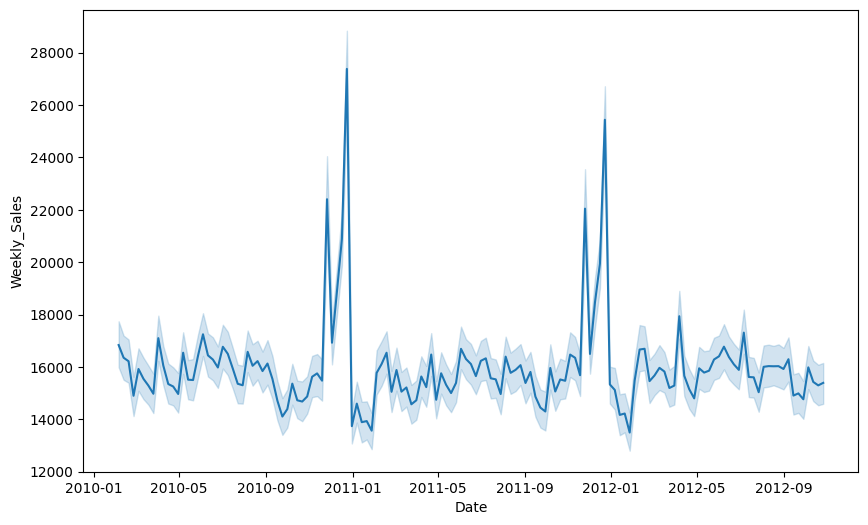

In [ ]:
from seaborn import lineplot
plt.figure(figsize=(10,6))
lineplot(data=train,x=train['Date'],y=train['Weekly_Sales'])
plt.show()

**with 1 week lag**

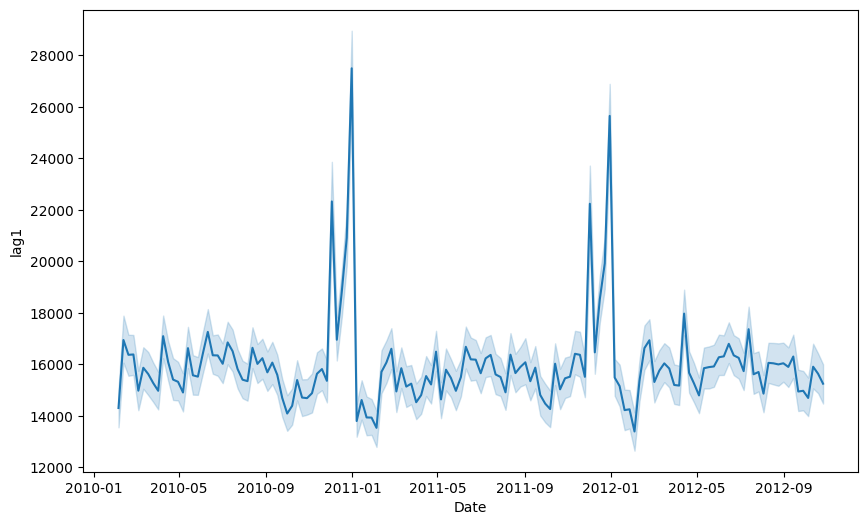

In [ ]:
plt.figure(figsize=(10,6))
lineplot(data=train,x=train['Date'],y=train['lag1'])
plt.show()

<Axes: >

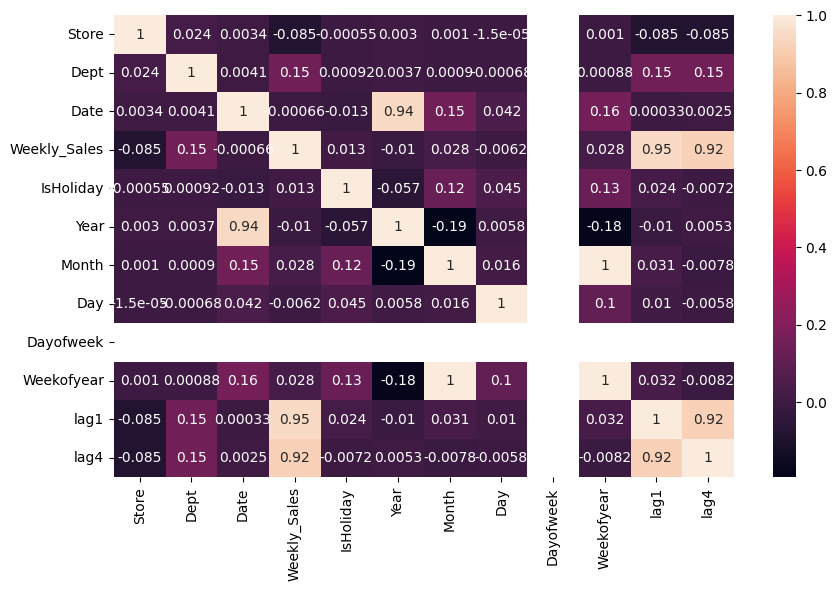

In [ ]:
corr = train.corr()
from seaborn import heatmap
plt.figure(figsize=(10,6))
heatmap(corr,annot=True)

**1 month lag**

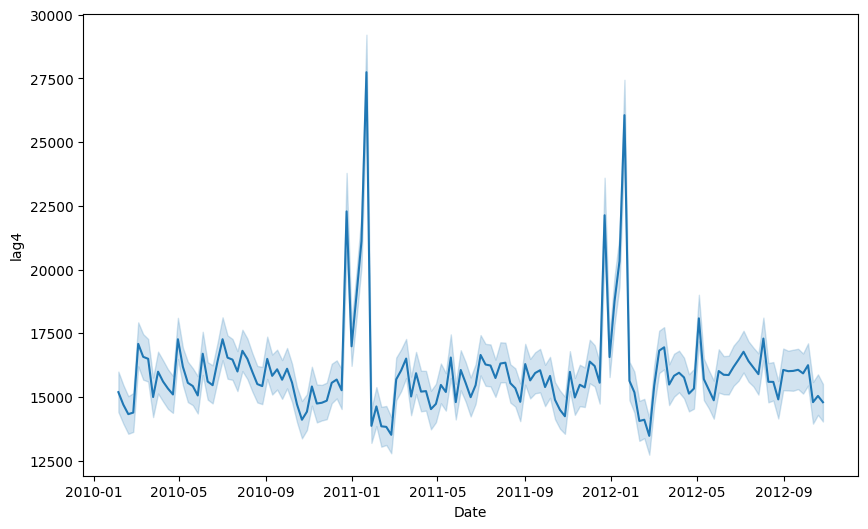

In [ ]:
plt.figure(figsize=(10,6))
lineplot(data=train,x=train['Date'],y=train['lag4'])
plt.show()

**Buiding the regessor model**

In [ ]:
#dropping lag as it causes data leakage
X= train.drop(['Weekly_Sales','Date','lag1','lag4'],axis=1)
y= train['Weekly_Sales']

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=10,test_size=0.2)

In [ ]:
model = XGBRegressor()

model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

**Training score**

In [ ]:
model.score(X_train,y_train)

0.9290770601602906

**Testing Score**

In [ ]:
model.score(X_test,y_test)

0.9273239257641626

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred.shape,y_test.shape

((84314,), (84314,))

In [ ]:
X_test['Date'] = pd.to_datetime(X_test[['Year', 'Month', 'Day']].astype(str).agg('-'.join, axis=1))

In [ ]:
X_test['Date']

,Date
190056,2011-08-26
174490,2010-03-12
142884,2011-08-05
63426,2012-08-17
344574,2010-12-24
...,...
140328,2011-04-22
299779,2010-11-05
291685,2012-09-07
163307,2011-09-23


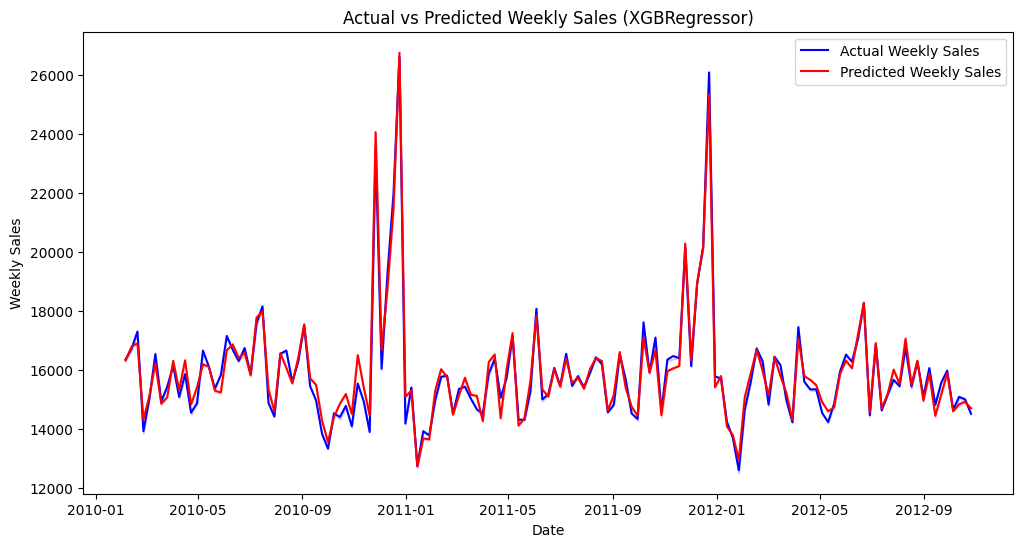

In [ ]:
from seaborn import lineplot

plt.figure(figsize=(12,6))
lineplot(x=X_test['Date'], y=y_test, label='Actual Weekly Sales', color='blue',errorbar=('ci',False))
lineplot(x=X_test['Date'], y=y_pred, label='Predicted Weekly Sales', color='red',errorbar=('ci',False))
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.title("Actual vs Predicted Weekly Sales (XGBRegressor)")
plt.legend()
plt.show()


**Prophet Model**

**Split into train and test**

In [ ]:
train_size=int(len(train)*0.8)
y_train = train[:train_size][['Weekly_Sales','Date']].rename(columns={'Date':'ds',"Weekly_Sales":'y'})
y_test = train[train_size:][['Weekly_Sales','Date']].rename(columns={'Date':'ds',"Weekly_Sales":'y'})

In [ ]:
y_train.shape,y_test.shape

((337256, 2), (84314, 2))

**Hyperparameter tune the model manually**

In [ ]:
lowest_rmse=np.inf
for changepoint_prior_scale in [0.01, 0.05, 0.1, 0.5]:
  for seasonality_prior_scale in [0.01, 0.1, 1.0, 10.0]:
    model = Prophet(weekly_seasonality=True,yearly_seasonality=True,changepoint_prior_scale=changepoint_prior_scale,seasonality_prior_scale=seasonality_prior_scale)
    model.fit(y_train)

    df_cv = cross_validation(
        model,
        initial="730 days",   # how much history for training
        horizon="90 days",    # forecast horizon
        period="180 days"     # step size between folds
    )
    metric = performance_metrics(df_cv, rolling_window=1)['rmse'].values[0]


    if metric < lowest_rmse:
      print(f"Metrics for changepoint_prior_scale={changepoint_prior_scale}, seasonality_prior_scale={seasonality_prior_scale}:")
      print(metric)
      lowest_rmse= metric
      best_cpps = changepoint_prior_scale
      best_sps = seasonality_prior_scale

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/0bl5uh5b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/zyb6hzh_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54715', 'data', 'file=/tmp/tmpfs7zj6ms/0bl5uh5b.json', 'init=/tmp/tmpfs7zj6ms/zyb6hzh_.json', 'output', 'file=/tmp/tmpfs7zj6ms/prophet_modeleg_ir1_0/prophet_model-20250914220921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:09:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2012-07-28 00:00:00 and 2012-07-28 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/el8eed_b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/yh8df1fa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52746', 'data', 'file=/tmp/tmpfs7zj6ms/el8eed_b.json', 'init=/tmp/tmpfs7zj6ms/yh8df1fa.json', 'output', 'file=/tmp/tmpfs7zj6ms/prophet_model6fp3eoey/prophet_model-20250914220957.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:10:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Metrics for changepoint_prior_scale=0.01, seasonality_prior_scale=0.01:
22503.347813661527


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/itiey4ng.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/7zf9e4eo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65392', 'data', 'file=/tmp/tmpfs7zj6ms/itiey4ng.json', 'init=/tmp/tmpfs7zj6ms/7zf9e4eo.json', 'output', 'file=/tmp/tmpfs7zj6ms/prophet_modelojc_18bo/prophet_model-20250914221048.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:11:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2012-07-28 00:00:00 and 2012-07-28 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/wn2bl0hy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/mzpok9uh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40044', 'data', 'file=/tmp/tmpfs7zj6ms/wn2bl0hy.json', 'init=/tmp/tmpfs7zj6ms/mzpok9uh.json', 'output', 'file=/tmp/tmpfs7zj6ms/prophet_modelgevpemtf/prophet_model-20250914221126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:11:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:11:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Metrics for changepoint_prior_scale=0.01, seasonality_prior_scale=0.1:
22502.68752018937


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/fp47dirk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/ifmgl1au.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56412', 'data', 'file=/tmp/tmpfs7zj6ms/fp47dirk.json', 'init=/tmp/tmpfs7zj6ms/ifmgl1au.json', 'output', 'file=/tmp/tmpfs7zj6ms/prophet_model2402156d/prophet_model-20250914221211.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2012-07-28 00:00:00 and 2012-07-28 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/4ge8_s06.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/nyv9ihfw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60057', 'data', 'file=/tmp/tmpfs7zj6ms/4ge8_s06.json', 'init=/tmp/tmpfs7zj6ms/nyv9ihfw.json', 'output', 'file=/tmp/tmpfs7zj6ms/prophet_modelv9wgslq8/prophet_model-20250914221243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/6mi11ixc.json
DEBUG:cmdstanpy:input tempfile:

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/2a4h46_s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/2vk1vl2u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13338', 'data', 'file=/tmp/tmpfs7zj6ms/2a4h46_s.json', 'init=/tmp/tmpfs7zj6ms/2vk1vl2u.json', 'output', 'file=/tmp/tmpfs7zj6ms/prophet_modelv8l6aqkv/prophet_model-20250914221408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:14:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:14:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Metrics for changepoint_prior_scale=0.01, seasonality_prior_scale=10.0:
22502.55960836008


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/f1ox6pn9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/l_dai01y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44794', 'data', 'file=/tmp/tmpfs7zj6ms/f1ox6pn9.json', 'init=/tmp/tmpfs7zj6ms/l_dai01y.json', 'output', 'file=/tmp/tmpfs7zj6ms/prophet_modell13sfp8b/prophet_model-20250914221457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:14:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:15:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2012-07-28 00:00:00 and 2012-07-28 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/6oxkyke8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/9jp954nn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4012', 'data', 'file=/tmp/tmpfs7zj6ms/6oxkyke8.json', 'init=/tmp/tmpfs7zj6ms/9jp954nn.json', 'output', 'file=/tmp/tmpfs7zj6ms/prophet_modelmmhed1c8/prophet_model-20250914221529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:15:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:15:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/n97rr7pk.json
DEBUG:cmdstanpy:input tempfile: 

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/fd6r5fxg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/xue19p86.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92167', 'data', 'file=/tmp/tmpfs7zj6ms/fd6r5fxg.json', 'init=/tmp/tmpfs7zj6ms/xue19p86.json', 'output', 'file=/tmp/tmpfs7zj6ms/prophet_model8_5r8bwh/prophet_model-20250914221704.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:17:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:17:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/cjktoxof.json
DEBUG:cmdstanpy:input tempfile:

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/2110r6ec.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/yjq4tgv6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67200', 'data', 'file=/tmp/tmpfs7zj6ms/2110r6ec.json', 'init=/tmp/tmpfs7zj6ms/yjq4tgv6.json', 'output', 'file=/tmp/tmpfs7zj6ms/prophet_model8o0bp_c0/prophet_model-20250914221835.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:18:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:19:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/xidxqo6h.json
DEBUG:cmdstanpy:input tempfile:

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/j8n_wtcu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/vc_pomdi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72363', 'data', 'file=/tmp/tmpfs7zj6ms/j8n_wtcu.json', 'init=/tmp/tmpfs7zj6ms/vc_pomdi.json', 'output', 'file=/tmp/tmpfs7zj6ms/prophet_model4r6_l8we/prophet_model-20250914222007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:20:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:20:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/eddfiwk5.json
DEBUG:cmdstanpy:input tempfile:

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/488c6_wt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/risa1p_l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62841', 'data', 'file=/tmp/tmpfs7zj6ms/488c6_wt.json', 'init=/tmp/tmpfs7zj6ms/risa1p_l.json', 'output', 'file=/tmp/tmpfs7zj6ms/prophet_modelhnqweyee/prophet_model-20250914222135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:21:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:21:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/mcvzahsf.json
DEBUG:cmdstanpy:input tempfile:

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/iwdptkp9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/ppf8n38g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89004', 'data', 'file=/tmp/tmpfs7zj6ms/iwdptkp9.json', 'init=/tmp/tmpfs7zj6ms/ppf8n38g.json', 'output', 'file=/tmp/tmpfs7zj6ms/prophet_modelxacm61hi/prophet_model-20250914222302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:23:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:23:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/uecge3ou.json
DEBUG:cmdstanpy:input tempfile:

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/42lct1_w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/pt8482qo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22036', 'data', 'file=/tmp/tmpfs7zj6ms/42lct1_w.json', 'init=/tmp/tmpfs7zj6ms/pt8482qo.json', 'output', 'file=/tmp/tmpfs7zj6ms/prophet_modelf7eaga7h/prophet_model-20250914222437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:24:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:25:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/9o05bxm9.json
DEBUG:cmdstanpy:input tempfile:

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/f1tcl2s5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/qzsd3y74.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63857', 'data', 'file=/tmp/tmpfs7zj6ms/f1tcl2s5.json', 'init=/tmp/tmpfs7zj6ms/qzsd3y74.json', 'output', 'file=/tmp/tmpfs7zj6ms/prophet_modelyh8jojyi/prophet_model-20250914222620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:26:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:26:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/n5yftgym.json
DEBUG:cmdstanpy:input tempfile:

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/zwggc71_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/p1ompfs7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57128', 'data', 'file=/tmp/tmpfs7zj6ms/zwggc71_.json', 'init=/tmp/tmpfs7zj6ms/p1ompfs7.json', 'output', 'file=/tmp/tmpfs7zj6ms/prophet_model586uu93e/prophet_model-20250914222759.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:27:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:28:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/r2ik2vj4.json
DEBUG:cmdstanpy:input tempfile:

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/vyy7po33.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/d0_snda8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71976', 'data', 'file=/tmp/tmpfs7zj6ms/vyy7po33.json', 'init=/tmp/tmpfs7zj6ms/d0_snda8.json', 'output', 'file=/tmp/tmpfs7zj6ms/prophet_model9yxhkof7/prophet_model-20250914222925.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:29:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:29:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/hokb83z9.json
DEBUG:cmdstanpy:input tempfile:

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/yvyfb4nx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/a64ebjbl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63014', 'data', 'file=/tmp/tmpfs7zj6ms/yvyfb4nx.json', 'init=/tmp/tmpfs7zj6ms/a64ebjbl.json', 'output', 'file=/tmp/tmpfs7zj6ms/prophet_modelrp8o45lz/prophet_model-20250914223054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:30:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:31:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/s9gio4lr.json
DEBUG:cmdstanpy:input tempfile:

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/3ymljpfw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/8_1v3jyi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99279', 'data', 'file=/tmp/tmpfs7zj6ms/3ymljpfw.json', 'init=/tmp/tmpfs7zj6ms/8_1v3jyi.json', 'output', 'file=/tmp/tmpfs7zj6ms/prophet_modelx74fzovu/prophet_model-20250914223221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:32:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:32:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Skipping MAPE because y close to 0


**Best Parameters with Scores**

In [ ]:
print(f"the lowest rmse is at {lowest_rmse} with changepoint_prior_scale = {best_cpps} and seasonality_prior scale = {best_sps}")

the lowest rmse is at 22502.55960836008 with changepoint_prior_scale = 0.01 and seasonality_prior scale = 10.0


**Build best model**

In [ ]:
model  = Prophet(weekly_seasonality=True,yearly_seasonality=True,changepoint_prior_scale=best_cpps,seasonality_prior_scale=best_sps)
model.fit(y_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/a2g823jg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfs7zj6ms/e1l_rus4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53341', 'data', 'file=/tmp/tmpfs7zj6ms/a2g823jg.json', 'init=/tmp/tmpfs7zj6ms/e1l_rus4.json', 'output', 'file=/tmp/tmpfs7zj6ms/prophet_modela621lmpz/prophet_model-20250914223315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:33:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:33:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=52, freq="W")
forecast = model.predict(future)

In [ ]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-02-05,22928.073378,-12382.264322,47303.034909,22928.073378,22928.073378,-5737.444038,-5737.444038,-5737.444038,-5989.266051,-5989.266051,-5989.266051,251.822013,251.822013,251.822013,0.0,0.0,0.0,17190.629341
1,2010-02-12,22939.020834,-13686.122192,48476.262166,22939.020834,22939.020834,-5503.286431,-5503.286431,-5503.286431,-5989.266051,-5989.266051,-5989.266051,485.979620,485.979620,485.979620,0.0,0.0,0.0,17435.734403
2,2010-02-19,22949.968290,-13830.186314,47179.275529,22949.968290,22949.968290,-6029.938435,-6029.938435,-6029.938435,-5989.266051,-5989.266051,-5989.266051,-40.672384,-40.672384,-40.672384,0.0,0.0,0.0,16920.029855
3,2010-02-26,22960.915745,-14887.031116,48419.594386,22960.915745,22960.915745,-6486.809303,-6486.809303,-6486.809303,-5989.266051,-5989.266051,-5989.266051,-497.543252,-497.543252,-497.543252,0.0,0.0,0.0,16474.106442
4,2010-03-05,22971.863201,-15433.357842,47127.778496,22971.863201,22971.863201,-6584.286698,-6584.286698,-6584.286698,-5989.266051,-5989.266051,-5989.266051,-595.020647,-595.020647,-595.020647,0.0,0.0,0.0,16387.576503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,2013-09-22,23250.883799,-8337.460158,50979.966487,23028.614890,23482.810974,-722.472988,-722.472988,-722.472988,998.214226,998.214226,998.214226,-1720.687214,-1720.687214,-1720.687214,0.0,0.0,0.0,22528.410811
191,2013-09-29,23254.500108,-8381.193170,54287.246384,23025.214287,23490.759408,-392.328440,-392.328440,-392.328440,998.214226,998.214226,998.214226,-1390.542666,-1390.542666,-1390.542666,0.0,0.0,0.0,22862.171668
192,2013-10-06,23258.116417,-5476.774598,53031.711031,23016.989066,23500.399678,75.692617,75.692617,75.692617,998.214226,998.214226,998.214226,-922.521609,-922.521609,-922.521609,0.0,0.0,0.0,23333.809034
193,2013-10-13,23261.732726,-9108.216984,53447.757870,23011.473466,23514.925903,137.935274,137.935274,137.935274,998.214226,998.214226,998.214226,-860.278951,-860.278951,-860.278951,0.0,0.0,0.0,23399.668000


**Actual vs Predicted Plot**

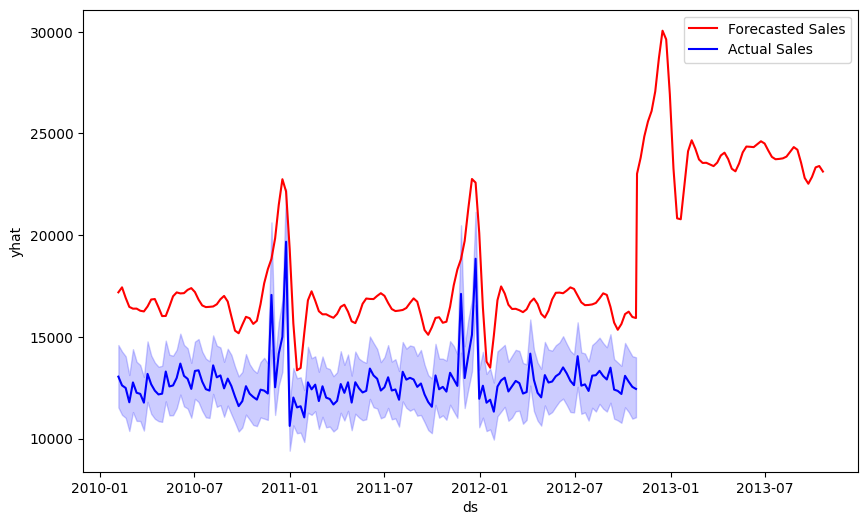

In [ ]:
from seaborn import lineplot
plt.figure(figsize=(10,6))
lineplot(data=forecast,x='ds',y='yhat',color='red', label='Forecasted Sales')
lineplot(data=y_test,x='ds',y='y',color='blue', label='Actual Sales')
plt.legend()
plt.show()
# the higher red forecasting as the data is unavailable after a certain period